In [1]:
# p.217 アンサンブル学習
from scipy.misc import comb
import math
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
            for k in range(k_start, n_classifier + 1)]
    return sum(probs)

ensemble_error(n_classifier=11, error=0.25)

/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  import sys


0.03432750701904297

In [2]:
import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
             for error in error_range]

import matplotlib.pyplot as plt
plt.plot(error_range, ens_errors,
        label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range,
        linestyle='--', label='Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Endemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  import sys


<Figure size 640x480 with 1 Axes>

In [3]:
import numpy as np
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

In [4]:
ex = np.array([[0.9, 0.1],
             [0.8, 0.2],
             [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
print(p)
np.argmax(p)

[0.58 0.42]


0

In [5]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """ 多数決アンサンブル分類器
    
    パラメータ
    ------------
    classifiers : array-like, shape = [n_classifiers]
        アンサンブルの様々な分類器
        
    vote : str, {'classlabel', 'probability'} (default: 'classlabel')
        'classlabel'の場合、クラスラベルの予測はクラスラベルのargmaxに基づく
        'probabilityの場合、クラスラベルの予測はクラスの所属確率のargmaxに基づく(分類器が調整済みであることが推奨される)'
        
    weights: array-like, shape = [n_classifiers] (optional, default=None)
        'int'まｍたは'float'型の値のリストが提供された場合、分類器は重要度で重み付けされる
        'weights=None'の場合は均一な重みを使用
    """
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """ 分類器を学習させる
        
        パラメータ
        ------------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            トレーニングサンプルからなる行列
        y : array-like, shape = [n_samples]
            クラスラベルのベクトル
            
        戻り値
        ------------
        self : object
        """
        
        # LabelEncoderを使ってクラスラベルが0から始まるようにエンコードする
        # self.predictのnp.argmax呼び出しで重要となる
        self.labelenc_ = LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_ = self.labelenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """ Xのクラスラベルを予測する
        
        パラメータ
        ------------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            トレーニングアンサンブルからなる行列
            
        戻り値
        ------------
        maj_vote : array-like, shape = [n_samples]
            予測されたクラスラベル
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else: # 'classlabel'での多数決
            
            # clf.predict呼び出しの結果を収集
            predictions = np.asarray([clf.predict(X)
                                     for clf in self.classifiers_]).T
            
            # 各サンプルのクラス確率に重みを掛けて足し合わせた値が最大となる
            # 列番号を配列として返す
            maj_vote = np.apply_along_axis(
                lambda x:
                np.argmax(np.bincount(x, weights=self.weights)),
                axis=1,
                arr=predictions)
            
        # 各サンプルに確率の最大値を与えるクラスラベルを抽出
        maj_vote = self.labelenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """ Xのクラス確率を予測する
        
        パラメータ
        ------------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            トレーニングベクトル:n_samplesはサンプルの個数、
            n_featuresは特徴量の個数
            
        戻り値
        ------------
        avg_proba : array-like, shape = [n_samples, n_classes]
            各サンプルに対する各クラスで重み付けた平均確率
        """
        probas = np.array([clf.predict_proba(X)
                          for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """ GridSearchの実行時に分類器のパラメータ名を取得 """
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            # キーを"分類機の名前__パラメータ名"、
            # バリューをパラメータの値とするディクショナリを生成
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
clf1 = LogisticRegression(penalty='l2',
                         C=0.001,
                         random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
                             criterion='entropy',
                             random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                           p=2,
                           metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()],
                 ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                 ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross varidaton:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

10-fold cross varidaton:

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/skl

In [9]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
         % (scores.mean(), scores.std(), label))

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/skl

ROC AUC: 0.94 (+/- 0.13) [Majority voting]


/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/skl

/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


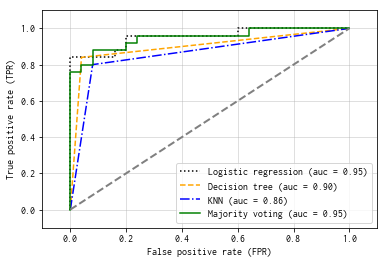

In [10]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # 陽性クラスのラベルは1であることが前提
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
            color=clr,
            linestyle=ls,
            label='%s (auc = %0.2f)' % (label, roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
        linestyle='--',
        color='gray',
        linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


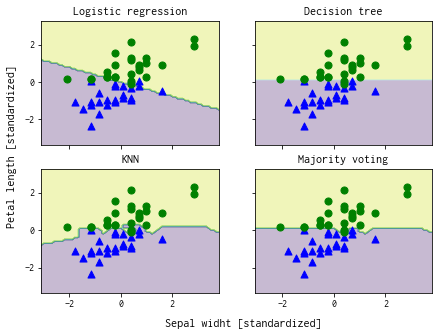

In [11]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product

# 決定領域を描画する最小値、最大値を生成
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

# グリッドポイントを生成
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

# 描画領域を2行2列に分割
f, axarr = plt.subplots(nrows=2, ncols=2,
                       sharex='col',
                       sharey='row',
                       figsize=(7, 5))

# 決定領域のプロット、青や赤の散布図の作成などを実行
# 変数idxは各分類器を描画する行と列の位置を表すタプル
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                 X_train_std[y_train==0, 1],
                                 c='blue',
                                 marker='^',
                                 s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                 X_train_std[y_train==1, 1],
                                 c='green',
                                 marker='o',
                                 s=50)
    axarr[idx[0], idx[1]].set_title(tt)
    
plt.text(-3.5, -5.,
        s='Sepal widht [standardized]',
        ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
        s='Petal length [standardized]',
        ha='center', va='center',
        fontsize=12, rotation=90)
plt.show()

In [12]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=1, solver='warn',
           tol=0.0001, verbose=0, warm_start=False)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'pipeline-2': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=Non

In [13]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2],
         'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf,
                   param_grid=params,
                   cv=10,
                   scoring='roc_auc')
grid.fit(X_train, y_train)

/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/skl

/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/nagahamanil/.pyenv/versions/3.6.7/lib/python3.6/site-packages/skl

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2'...',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [14]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
         % (grid.cv_results_['mean_test_score'][r],
           grid.cv_results_['std_test_score'][r] / 2.0,
           grid.cv_results_['params'][r]))
    
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.933 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Accuracy: 0.97


In [15]:
import pandas as pd
df_wine = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',
    header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

# クラス1を削除
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [17]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                             max_depth=None,
                             random_state=1)
bag = BaggingClassifier(base_estimator=tree,
                       n_estimators=500,
                       max_samples=1.0,
                       max_features=1.0,
                       bootstrap=True,
                       bootstrap_features=False,
                       n_jobs=1,
                       random_state=1)

In [18]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


In [19]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.917


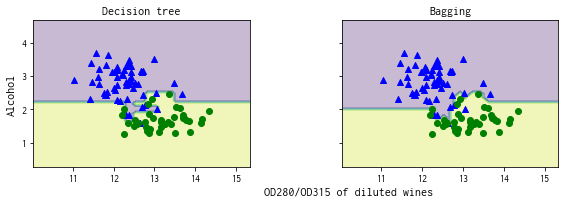

In [20]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,
                       sharex='col',
                       sharey='row',
                       figsize=(8, 3))

for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                      X_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],
                      X_train[y_train==1, 1], c='green', marker='o')
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5, s='OD280/OD315 of diluted wines',
        ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()

In [21]:
# p.242 7.5.2 scikit-learnを使ってアダブーストを適用する
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                             max_depth=1,
                             random_state=1)
ada = AdaBoostClassifier(base_estimator=tree,
                        n_estimators=500,
                        learning_rate=0.1,
                        random_state=1)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 0.916/0.875


In [22]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train, ada_test))

AdaBoost train/test accuracies 1.000/0.917


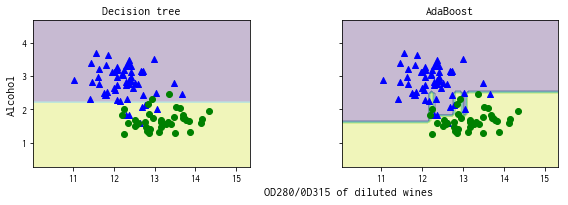

In [23]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(1, 2, sharex='col',
                       sharey='row',
                       figsize=(8, 3))
for idx, clf, tt in zip([0, 1], [tree, ada], ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1],
                      c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1],
                      c='green', marker='o')
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -0.5,
        s='OD280/0D315 of diluted wines',
        ha='center',
        va='center',
        fontsize=12)
plt.tight_layout()
plt.show()